In [27]:
import glob
import matplotlib.pyplot as plt
import xarray as xr
import os
import calendar
import pandas as pd
import datetime
import gcsfs

In [3]:
folder = 'C:/Users/LENOVO/Downloads/Climate Tutorial/'
files =  os.listdir(folder)
#removing the last index of the list which is a folder
files.pop()
files

['precip.V1.0.2018.nc',
 'precip.V1.0.2019.nc',
 'precip.V1.0.2020.nc',
 'precip.V1.0.2021.nc',
 'precip.V1.0.2022.nc']

In [4]:
paths = []
for file in files:
        file_path = os.path.join(folder,file)
        paths.append(file_path)
paths

['C:/Users/LENOVO/Downloads/Climate Tutorial/precip.V1.0.2018.nc',
 'C:/Users/LENOVO/Downloads/Climate Tutorial/precip.V1.0.2019.nc',
 'C:/Users/LENOVO/Downloads/Climate Tutorial/precip.V1.0.2020.nc',
 'C:/Users/LENOVO/Downloads/Climate Tutorial/precip.V1.0.2021.nc',
 'C:/Users/LENOVO/Downloads/Climate Tutorial/precip.V1.0.2022.nc']

In [5]:
# ds21 = xr.open_dataset(folder+'precip.V1.0.2021.nc')
ds22 = xr.open_dataset(folder+'precip.V1.0.2022.nc')

c:\Users\LENOVO\anaconda3\envs\infarmer_env\lib\site-packages\ecmwflibs\__init__.py:83: UserWarning: DLL load failed while importing _ecmwflibs: The specified procedure could not be found.
  warnings.warn(str(e))
c:\Users\LENOVO\anaconda3\envs\infarmer_env\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
ds22

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 365)
Coordinates:
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 04/2010 by CAS from data obtained from NCEP/CPC\n...
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

In [7]:
# ds2021_2022 = xr.merge([ds21,ds22])

In [8]:
# Open and concatenate the netCDF files
ds_merged = xr.open_mfdataset(paths, combine='by_coords',chunks={'time': 200})
ds_merged

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 1826)
Coordinates:
  * lat      (lat) float32 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * lon      (lon) float32 230.1 230.4 230.6 230.9 ... 304.1 304.4 304.6 304.9
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(200, 120, 300), meta=np.ndarray>
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 04/2010 by CAS from data obtained from NCEP/CPC\n...
    description:    Gridded daily Precipitation
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    References:     http://www.psl.noaa.gov/data/gridded/data.unified.daily.c...

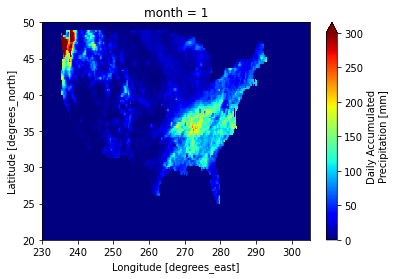

In [9]:
ds22_mon = ds22.groupby('time.month')
# Calculate the mean for each month
ds_monthly_sum = ds22_mon.sum(dim='time')
ds_monthly_sum
ds_monthly_sum.precip[0,:,:].plot(cmap='jet', vmax=300)

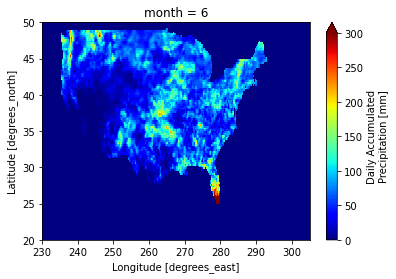

In [10]:
ds_monthly_sum.precip[5,:,:].plot(cmap='jet', vmax=300)

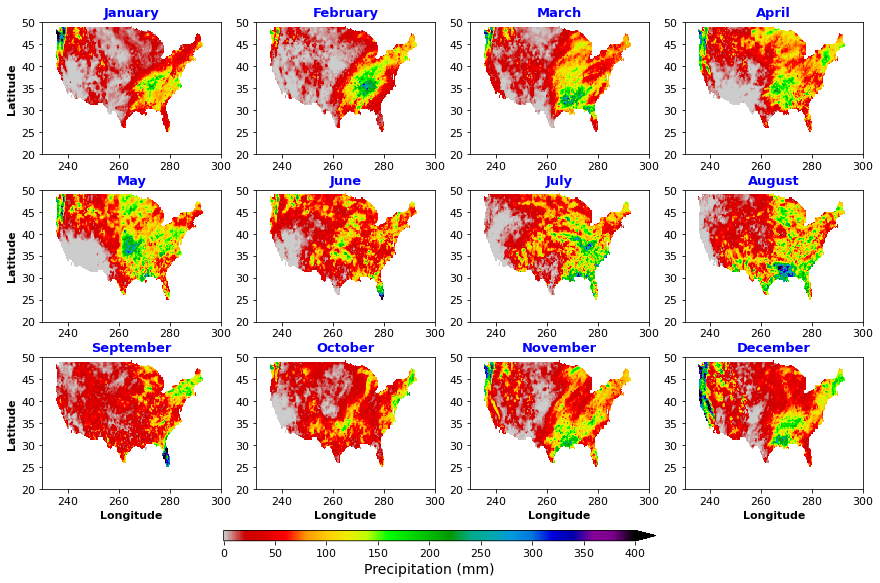

In [11]:
# First, We will develop a land mask data array that we can use to mask out the nan values:
landmask = ds22.precip.sum(dim='time')>0

fig = plt.figure(figsize=[12,8], facecolor='w')
plt.subplots_adjust(bottom=0.15, top=0.96, left=0.04, right=0.99, 
                    wspace=0.2, hspace=0.27) # wspace and hspace adjust the horizontal and vertical spaces, respectively.
nrows = 3
ncols = 4
# plt.title('Monthly Precipitation sum for USA-2022')

for i in range(1, 13):
    plt.subplot(nrows, ncols, i)
    dataplot = ds_monthly_sum.precip[i-1, :, :].where(landmask) # Remember that in Python, the data index starts at 0, but the subplot index start at 1.
    p = plt.pcolormesh(ds_monthly_sum.lon, ds_monthly_sum.lat, dataplot,
                   vmax = 400, vmin = 0, cmap = 'nipy_spectral_r',
                   ) 
    plt.xlim([230,300])
    plt.ylim([20,50])
    plt.title(calendar.month_name[dataplot.month.values], fontsize = 13, 
              fontweight = 'bold', color = 'b')
    plt.xticks(fontsize = 11)
    plt.yticks(fontsize = 11)
    if i % ncols == 1: # Add ylabel for the very left subplots
        plt.ylabel('Latitude', fontsize = 11, fontweight = 'bold')
    if i > ncols*(nrows-1): # Add xlabel for the bottom row subplots
        plt.xlabel('Longitude', fontsize = 11, fontweight = 'bold')

# Add a colorbar at the bottom:
cax = fig.add_axes([0.25, 0.06, 0.5, 0.018])
cb = plt.colorbar(cax=cax, orientation='horizontal', extend = 'max',)
cb.ax.tick_params(labelsize=11)
cb.set_label(label='Precipitation (mm)', color = 'k', size=14)

# Now we can save a high resolution (300dpi) version of the figure:
# plt.savefig('Fig_prec_cpc_mon_2012.png', format = 'png', dpi = 300)

Now let's say we want to extract data for a specific boundary and look at the average condition within that area of interest. For simplicity, we can think of a rectangular box (but you can easily develop any landmask as above and use it to focus on only your domain of interest). For this case, let's look at a rectangular box almost similar to the state of Kansas.

In [12]:
top = 40
bottom = 37
left = 258
right = 265.4
ds_sel = ds_merged.isel(lon=(ds_merged.lon >= left) & (ds_merged.lon <= right),
                          lat=(ds_merged.lat >= bottom) & (ds_merged.lat <= top),
                          )
ds_sel_avg = ds_sel.mean(dim=['lat','lon'])

In [13]:
#Now let's plot the cumulative daily precipitation of the selected area for each year. To make things easier, let's drop Feb 29th from any leap years in the record. Here we go:
ds_sel_avg_noleap = ds_sel_avg.sel(
    time=~((ds_sel_avg.time.dt.month == 2) & (ds_sel_avg.time.dt.day == 29)))

In [14]:
ds_sel_avg_noleap

<xarray.Dataset>
Dimensions:  (time: 1825)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2022-12-31
Data variables:
    precip   (time) float32 dask.array<chunksize=(200,), meta=np.ndarray>

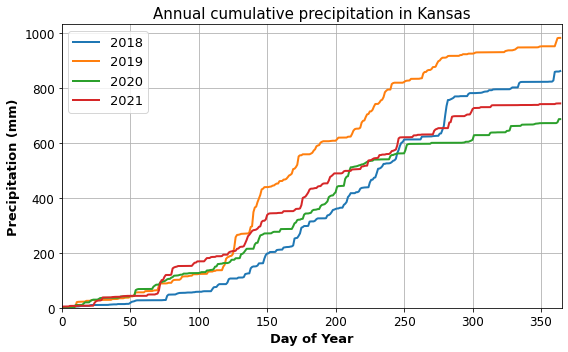

In [15]:
fig = plt.figure(figsize=[8,5], facecolor='w')
for yr in range(2018,2022):
    da_yr = ds_sel_avg_noleap.isel(time = ds_sel_avg_noleap.time.dt.year==yr).precip
    dataplot = da_yr.cumsum()
    plt.plot(dataplot, linewidth=2, label = yr)
plt.legend(fontsize=13)
plt.grid()
plt.xticks(fontsize=12) # we can also change the ticks to be on Jan-1, Feb-1, etc. but I'll skip it for here.
plt.yticks(fontsize=12)
plt.ylabel('Precipitation (mm)', fontsize = 13, fontweight = 'bold')
plt.xlabel('Day of Year', fontsize = 13, fontweight = 'bold')
plt.xlim([0,365])
plt.ylim(bottom=0)
plt.title('Annual cumulative precipitation in Kansas', fontsize=15)
plt.tight_layout()
# plt.savefig('Fig_cumsum_prec_Kansas.png', format = 'png', dpi = 300)

In [16]:
# Now lets open the two datasets and explore them:
ds_gridmet = xr.open_dataset(folder+'/tmin/tmmn_2022.nc')
ds_CPC = xr.open_dataset(folder+'/tmin/tmin_2022.nc')

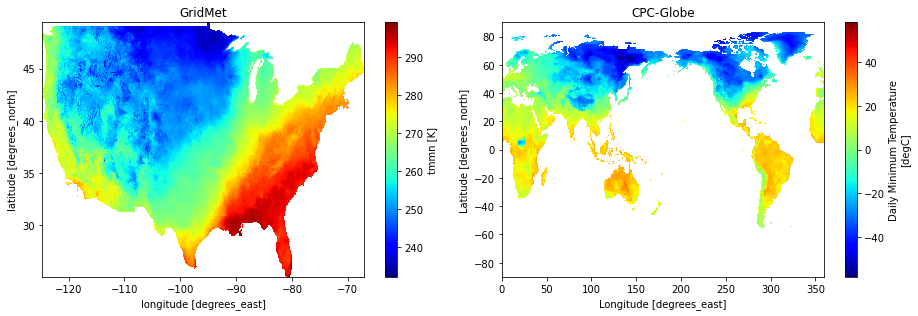

In [17]:
# Let's plot the original data for Jan 1st:
fig = plt.figure(figsize = [13,4.5])
plt.subplot(1,2,1)
ds_gridmet.air_temperature[0,:,:].plot(cmap = 'jet')
plt.title('GridMet')
plt.subplot(1,2,2)
ds_CPC.tmin[0,:,:].plot(cmap = 'jet')
plt.title('CPC-Globe')
plt.tight_layout()

In [29]:
'''Looking at the two datasets, we see that there are a few differences that should be addressed:

In the gridmet dataset, the "crs" coordinate can be dropped, and the "day" coordinate can be renamed to "time" to be consistent with the CPC dataset (similarly for "air_temperature").
The gridmet data is in Kelvin, but CPC is in Celcius. Let's convert gridmet data to Celcius.
In addition, the lon coordinate in one dataset is 0:360 and -180:180 in the other one. Let's change that to 0:360 for the gridmet data.
Lastly, let's interpolate the coarser resolution data (CPC-Globe) to the gridmet resolution.'''

ds_gridmet_revised = ds_gridmet.drop('crs').rename({'day':'time', 'air_temperature':'tmin'})
ds_gridmet_revised = ds_gridmet_revised-273.15 # Convert Kelvin to Celcius
lon_revised = ds_gridmet.lon + (ds_gridmet.lon < 0)*360
ds_gridmet_revised = ds_gridmet_revised.assign_coords(lon = lon_revised)

In [30]:
ds_gridmet_revised

<xarray.Dataset>
Dimensions:  (lon: 1386, lat: 585, time: 365)
Coordinates:
  * lon      (lon) float64 235.2 235.3 235.3 235.4 ... 292.8 292.9 292.9 292.9
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Data variables:
    tmin     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       305
    last_early_slice:           365
    last_provisional_slice:     359
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [31]:
ds_CPC_interp = ds_CPC.interp(lat = ds_gridmet_revised.lat, lon = ds_gridmet_revised.lon)

In [32]:
'''Great! We did all that with just a few lines of code. Please note that in interpolation, the data boundary (i.e. latlon bounds) are also matched to the output boundary.

Now let's take a look at Feb 16, 2021 for the regions in Texas, where a severe cold storm happened. I did a quick analysis for that event last year and you can take a look at that in this link: https://www.linkedin.com/pulse/how-unusual-2021-texas-cold-span-ali-ahmadalipour/

To make the temporal analyses easier, we first make sure that the "time" coordinate is in proper datetime format.'''

ds_gridmet_revised = ds_gridmet_revised.assign_coords(
    time = pd.to_datetime(ds_gridmet_revised.time))
ds_CPC_interp = ds_CPC_interp.assign_coords(
    time = pd.to_datetime(ds_CPC_interp.time))

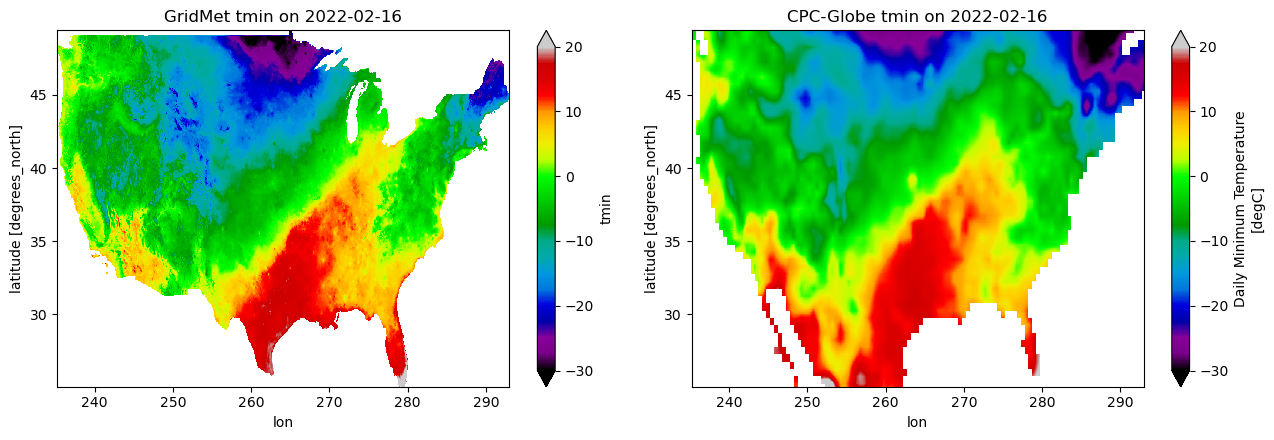

In [33]:
target_date = datetime.date(2022,2,16)
target_date = pd.to_datetime(target_date)

fig = plt.figure(figsize = [13,4.5], facecolor='w')
plt.subplot(1,2,1)
ds_gridmet_revised.sel(time=target_date).tmin.plot(cmap = 'nipy_spectral', vmin = -30, vmax = 20)
plt.title(f'GridMet tmin on {target_date.strftime("%Y-%m-%d")}')

plt.subplot(1,2,2)
ds_CPC_interp.sel(time=target_date).tmin.plot(cmap = 'nipy_spectral', vmin = -30, vmax = 20)
plt.title(f'CPC-Globe tmin on {target_date.strftime("%Y-%m-%d")}')
plt.tight_layout()

In [34]:
'''It can be seen that the interpolated data (CPC plot shown on right) does not necessarily have the details (specially the orographic and elevation effects) of the finer resolution data.

Now let's find the spatial mean of both datasets around Austin, TX. Again, to make it simpler, I defined an estimate rectangular boundary that we will use.'''
# Rough boundaries for Austin, TX:
left = 360 - 97.9
right = 360 - 97.6
top = 30.5
bottom = 30.2

ds_Austin_gridmet = ds_gridmet_revised.isel(
    lon=(ds_gridmet_revised.lon >= left) & (ds_gridmet_revised.lon <= right),
    lat=(ds_gridmet_revised.lat >= bottom) & (ds_gridmet_revised.lat <= top),
).mean(dim=['lat','lon'])
ds_Austin_CPC = ds_CPC_interp.isel(
    lon=(ds_CPC_interp.lon >= left) & (ds_CPC_interp.lon <= right),
    lat=(ds_CPC_interp.lat >= bottom) & (ds_CPC_interp.lat <= top),
).mean(dim=['lat','lon'])


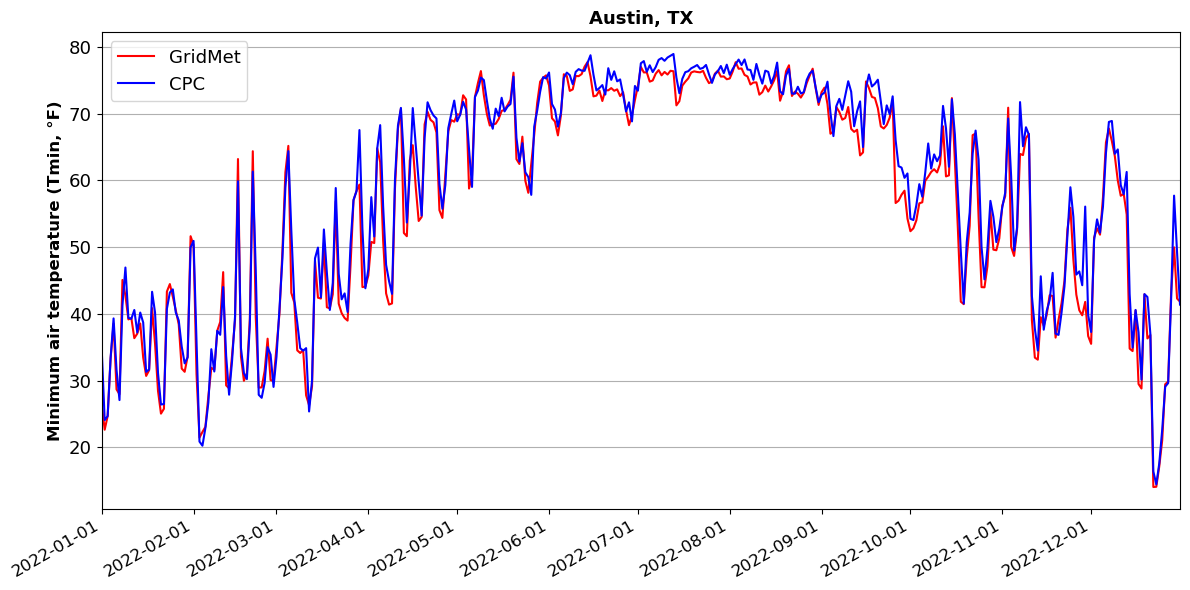

In [35]:
plt.figure(figsize = [12,6])
(ds_Austin_gridmet.tmin*1.8 + 32).plot(label = 'GridMet', color = 'r')
(ds_Austin_CPC.tmin*1.8 + 32).plot(label = 'CPC', color = 'b')
plt.grid(axis='y')
plt.xticks(ticks = [datetime.date(2022,x,1) for x in range(1,13)], fontsize=12)
plt.xlim([datetime.date(2022,1,1), datetime.date(2022,12,31)])
plt.yticks(fontsize=13)
plt.ylabel('Minimum air temperature (Tmin, °F)', fontsize = 12, 
           fontweight = 'bold')
plt.xlabel('')
plt.legend(fontsize=13, loc = 'upper left')
plt.title('Austin, TX', fontsize=13, fontweight = 'bold')
plt.tight_layout()

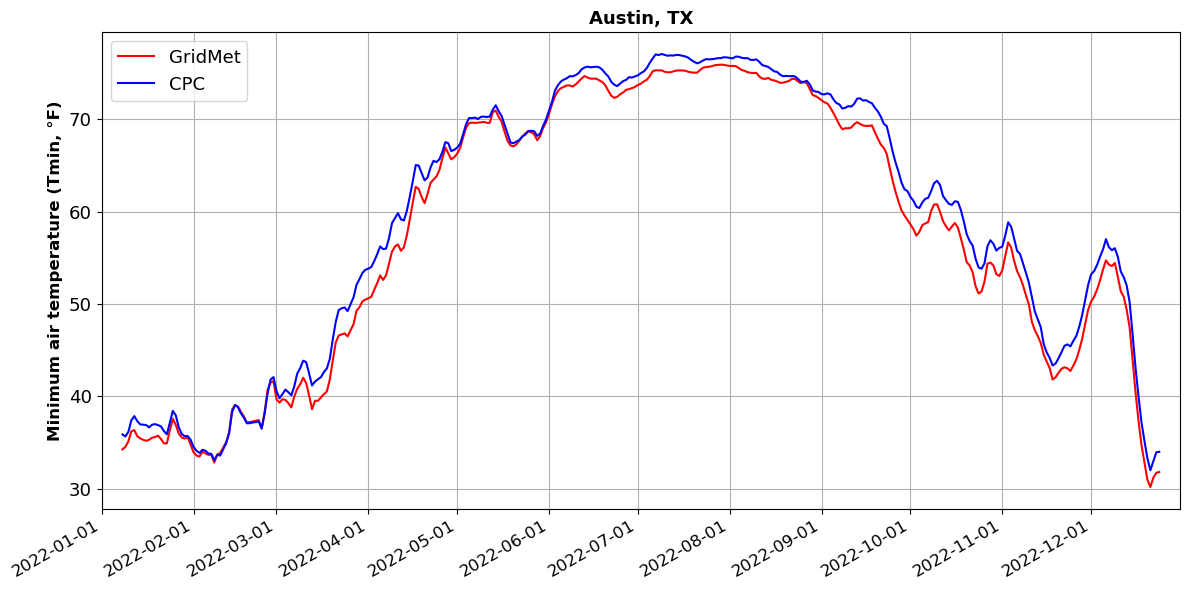

In [36]:
'''As you can see, the two datasets are considerably different (more than 10°F) in late February and late October. Notably,
daily temperature has a lot of noise (short-term variation). To have a smoother plot, let's calculate the moving average of tmin with a 15-day window:'''

plt.figure(figsize = [12,6])
(ds_Austin_gridmet.tmin*1.8 + 32).rolling(time=15,center=True).mean().plot(label = 'GridMet', color = 'r')
(ds_Austin_CPC.tmin*1.8 + 32).rolling(time=15,center=True).mean().plot(label = 'CPC', color = 'b')
plt.grid()
plt.xticks(ticks = [datetime.date(2022,x,1) for x in range(1,13)], fontsize=12)
plt.xlim([datetime.date(2022,1,1), datetime.date(2022,12,31)])
plt.yticks(fontsize=13)
plt.ylabel('Minimum air temperature (Tmin, °F)', fontsize = 12, 
           fontweight = 'bold')
plt.xlabel('')
plt.legend(fontsize=13, loc = 'upper left')
plt.title('Austin, TX', fontsize=13, fontweight = 'bold')
plt.tight_layout()

The df table includes information for all climate change model runs that are available on Google Cloud Storage. As of March 2022, there are over half a million different model outputs (e.g. different models, variables, timescales, scenarios, ensemble member, etc.). Let's narrow down the outputs to only those of monthly air temperature in historical and ssp585 scenario:

In [20]:
df = pd.read_csv(folder+'/tmin/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [26]:
df_ssp585 = df.query("activity_id=='ScenarioMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tas' & experiment_id == 'ssp585' & member_id == 'r1i1p1f1'")
print('Length of df_ssp585:', len(df_ssp585))
df_ssp585.head(3)

Length of df_ssp585: 35


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
866,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701
19008,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
66586,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/BCC/BCC-CSM2-MR/s...,NaN,20190314


In [23]:
'''Ok, much better. In summary, our CMIP6 search is narrowed down to 55 historical models and 35 ssp585 future monthly temperature "forecasts". In a decent climate change study, we should first evaluate the models during the historical period and then select a sub-set of models that outperform at the region of interest. 
However, since this is just an exercise, I will only choose one model that has data in both historical and future periods.'''

df_historical = df.query("activity_id == 'CMIP' & table_id == 'Amon' & " +\
    "variable_id == 'tas' & experiment_id == 'historical' & member_id == 'r1i1p1f1'")
print(df_historical)
print('Length of df_historical:', len(df_historical))
df_historical.head(3)

       activity_id       institution_id          source_id experiment_id  \
8074          CMIP            NOAA-GFDL           GFDL-CM4    historical   
29231         CMIP                 IPSL       IPSL-CM6A-LR    historical   
32351         CMIP            NASA-GISS        GISS-E2-1-G    historical   
43297         CMIP                  BCC        BCC-CSM2-MR    historical   
44593         CMIP                MIROC             MIROC6    historical   
44888         CMIP                  BCC           BCC-ESM1    historical   
55765         CMIP                  MRI         MRI-ESM2-0    historical   
56326         CMIP                 NCAR        CESM2-WACCM    historical   
59875         CMIP                 NCAR              CESM2    historical   
68153         CMIP                  SNU        SAM0-UNICON    historical   
69515         CMIP            NASA-GISS        GISS-E2-1-H    historical   
100305        CMIP                CCCma            CanESM5    historical   
204283      

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
8074,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
29231,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...,NaN,20180803
32351,CMIP,NASA-GISS,GISS-E2-1-G,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/hi...,NaN,20180827


In [28]:
model = 'GFDL-CM4'
zstore_hist = df_historical.query(f"source_id == '{model}'").zstore.values[0]
zstore_ssp585 = df_ssp585.query(f"source_id == '{model}'").zstore.values[0]
gcs = gcsfs.GCSFileSystem(token='anon')

In [31]:
mapper = gcs.get_mapper(zstore_hist)
ds_hist = xr.open_zarr(mapper, consolidated = True)
mapper = gcs.get_mapper(zstore_ssp585)
ds_ssp585 = xr.open_zarr(mapper, consolidated = True)

In [37]:
ds_hist

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1980)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-07;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e4193a02-6405-49b6-8ad3-65def741a4dd...
    version_id:             v20180701

In [38]:
'''Looking at the metadata of the two datasets, the data periods can be beyond our interest (historical: 1850-2014, ssp585: 2015-2100). 
Therefore, we can select our period of interest and then load the subset of data for more convenience in further analyses. 
But before that, the time coordinate is in "object" format, which we need to convert to datetime to be able to easily analyze the timeseries.'''

print('hist date range  :', ds_hist.time[0].values, ' , ', ds_hist.time[-1].values)
print('ssp585 date range:', ds_ssp585.time[0].values, ' , ', ds_ssp585.time[-1].values)

hist date range  : 1850-01-16 12:00:00  ,  2014-12-16 12:00:00
ssp585 date range: 2015-01-16 12:00:00  ,  2100-12-16 12:00:00


In [39]:
start_time = pd.to_datetime(datetime.date(1850,1,15)) # I chose 15 for all dates to make it easier.
time_new_hist = [start_time + pd.DateOffset(months = x) for x in range(len(ds_hist.time))]

start_time = pd.to_datetime(datetime.date(2015,1,15))
time_new_ssp585 = [start_time + pd.DateOffset(months = x) for x in range(len(ds_ssp585.time))]

In [40]:
ds_hist = ds_hist.assign_coords(time = time_new_hist)
ds_ssp585 = ds_ssp585.assign_coords(time = time_new_ssp585)

In [41]:
start_date = pd.to_datetime(datetime.date(1980,1,1))
end_date = pd.to_datetime(datetime.date(2010,12,31))
ds_hist_sel = ds_hist.isel(time=(ds_hist.time >= start_date) & (ds_hist.time <= end_date))

start_date = pd.to_datetime(datetime.date(2070,1,1))
end_date = pd.to_datetime(datetime.date(2099,12,31))
ds_ssp585_sel = ds_ssp585.isel(time=(ds_ssp585.time >= start_date) & (ds_ssp585.time <= end_date))

In [42]:
ds_hist_sel.load()
ds_ssp585_sel.load()

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 360)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 0.0 1.25 1.25 2.5 ... 357.5 358.8 358.8 360.0
  * time       (time) datetime64[ns] 2070-01-15 2070-02-15 ... 2099-12-15
    time_bnds  (time, bnds) object 2070-01-01 00:00:00 ... 2100-01-01 00:00:00
Data variables:
    tas        (time, lat, lon) float32 242.4 242.4 242.4 ... 269.6 269.6 269.6
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tas
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-13;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/991bc4a4-20d5-4a58-a451-6b3ea33116be
    version_id:             v20180701

In [45]:
tas_avg_hist = ds_hist_sel.groupby('time.month').mean()
tas_avg_ssp585 = ds_ssp585_sel.groupby('time.month').mean()

In [46]:
tas_30yr_diff = tas_avg_ssp585 - tas_avg_hist

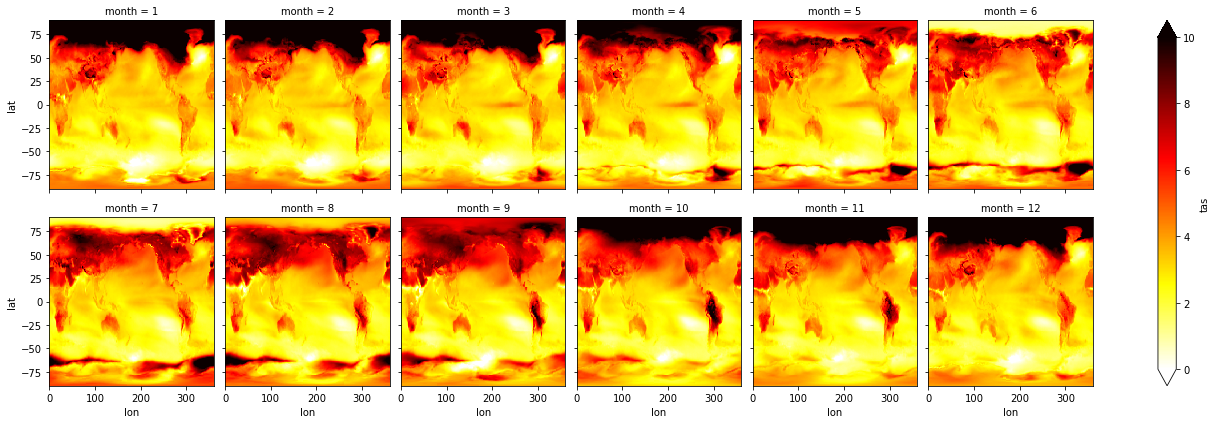

In [47]:
tas_30yr_diff.tas.plot(col = 'month', col_wrap = 6, vmax = 10, vmin = 0, cmap = 'hot_r')

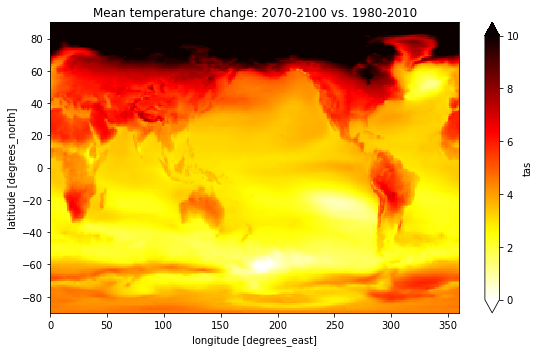

In [48]:
''' And here's a plot for the annual mean change:
'''
tas_30yr_diff.mean('month').tas.plot(figsize=[8,5], cmap = 'hot_r', 
                                     vmin = 0, vmax = 10)
plt.title('Mean temperature change: 2070-2100 vs. 1980-2010')
plt.tight_layout()

In [49]:
'''The above plots show that in an extreme scenario (ssp585), the annual mean temperature in northern latitudes can be above 10°C warmer than the historical period, 
and the same for mid-latitudes can be ~5-7°C warmer. Please note that this is the result of one GCM realization at coarse resolution. In practice, 
these outputs should be first bias-corrected and downscaled before further analysis.

Now, let's try an example and work with timeseries data (instead of 30-year mean). Let's look at the annual temperature change of each year.
'''
tas_avg_hist_yr = tas_avg_hist.mean('month')

In [50]:
tas_change_yr = ds_ssp585_sel.groupby('time.year').mean('time')

In [51]:
tas_change_yr = tas_change_yr - tas_avg_hist_yr

In [52]:
'''Now, let's make a timelapse video for annual temperature change. To have a smooth video, we'll plot the 5-year rolling average.'''

tas_change_yr_rolling5 = tas_change_yr.rolling(year=5,center=True).mean().dropna('year').tas
# Make a directory to save all the figures there:
if not os.path.exists('./Figures_ssp585/'):
    os.makedirs('./Figures_ssp585/')

for i in range(len(tas_change_yr_rolling5)):
    dataplot = tas_change_yr_rolling5[i,:,:]
    # Convert 0:360 to -180:180 :
    dataplot = dataplot.assign_coords(lon = dataplot.lon - (dataplot.lon > 180)*360)
    dataplot = dataplot.sortby('lon', ascending=True)

    fig = plt.figure(figsize=[9,5], facecolor='w')
    # Adjust plot area (I find these by try and error until I get what I want)
    plt.subplots_adjust(left=0.075, right=0.895, bottom=0.1, top=0.93)
    plt.pcolormesh(dataplot.lon, dataplot.lat, dataplot, cmap='plasma', vmin=0, vmax=12)
    plt.title(f'Near-surface air temperature change: {model} ssp585, {dataplot.year.values} vs. 1980-2010',
              fontsize = 14)
    plt.ylabel('Latitude', fontsize = 12)
    plt.xlabel('Longitude', fontsize = 12)
    # Add colorbar:
    cax = fig.add_axes([0.91, 0.12, 0.02, 0.8])
    cb = plt.colorbar(cax=cax, orientation='vertical', extend = 'max')
    cb.ax.tick_params(labelsize=11)
    cb.set_label(label='Temperature Change (°C)', color = 'k', size=13)
    # Save and close figure:
    plt.savefig(f'./Figures_ssp585/Fig_tasChange_{dataplot.year.values}.png', 
                format = 'png', dpi=200)
    plt.close()

In [53]:
import cv2
import glob

In [54]:
files = glob.glob(f'./Figures_ssp585/Fig_tasChange*.png')
files.sort()

In [55]:
img_array = []
for filename in files:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
fps = 4
out = cv2.VideoWriter(f'Vid_tasChange_ssp585.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 4, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [43]:
'''We can define a region of interest and explore the spatial mean of the temperature change. For this example, we'll focus on the Northwest US (e.g. the Cascades):'''

left = 236
right = 240
bottom = 42
top = 49

tas_NW_yr_hist = ds_hist_sel.isel(lat = (ds_hist_sel.lat>=bottom) & (ds_hist_sel.lat<=top),
                   lon = (ds_hist_sel.lon>=left) & (ds_hist_sel.lon<=right),
                   ).mean(['lat','lon']).drop(['bnds', 'height', 'time_bnds'])
tas_NW_yr_ssp585 = ds_ssp585_sel.isel(lat = (ds_ssp585_sel.lat>=bottom) & (ds_ssp585_sel.lat<=top),
                   lon = (ds_ssp585_sel.lon>=left) & (ds_ssp585_sel.lon<=right),
                   ).mean(['lat','lon']).drop(['bnds', 'height', 'time_bnds'])

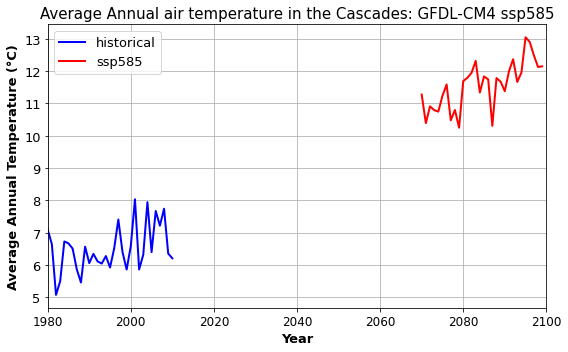

In [44]:
plt.figure(figsize=[8,5],)
(tas_NW_yr_hist.groupby('time.year').mean().tas-273.15).plot(
    label='historical', color='b', linewidth=2)
(tas_NW_yr_ssp585.groupby('time.year').mean().tas-273.15).plot(
    label='ssp585', color='r', linewidth=2)
plt.grid()
plt.xlim([1980,2100])
plt.legend(fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.ylabel('Average Annual Temperature (°C)', fontsize=13, fontweight='bold')
plt.xlabel('Year', fontsize=13, fontweight='bold')
plt.title(f'Average Annual air temperature in the Cascades: {model} ssp585',
          fontsize=15)

plt.tight_layout()